In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    make_sentence_vectorizer,
    get_3d_quartile_words_count,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS
)
from wordEmbeddingsLayers import get_russian_fasttext_word_vectorizer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Word Vectorizer

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
VECTORIZED_SENTENCE_LENTGH = get_3d_quartile_words_count(X_train.flatten())

fasttext_word_vectorizer, FASTTEXT_EMBEDDING_DIMENSION = get_russian_fasttext_word_vectorizer()

fasttext_sentence_vectorizer = make_sentence_vectorizer(
    vectorizer=fasttext_word_vectorizer,
    pad_sentence_to_n_words=VECTORIZED_SENTENCE_LENTGH
)

In [5]:
X_train = np.array(list(
    map(fasttext_sentence_vectorizer, X_train.flatten())
))

X_test = np.array(list(
    map(fasttext_sentence_vectorizer, X_test.flatten())
))

# Build RNN model

In [6]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=(VECTORIZED_SENTENCE_LENTGH, FASTTEXT_EMBEDDING_DIMENSION,), dtype=tf.float32),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.5, seed=SEED),
    layers.Dense(units=1,
#                  bias_initializer=initial_output_bias
                ),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [7]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 13s 553ms/step - loss: 0.6481 - binary_accuracy: 0.5818 - recall: 0.7113 - precision: 0.4390 - val_loss: 0.5009 - val_binary_accuracy: 0.7355 - val_recall: 0.2396 - val_precision: 0.8762
Epoch 2/10
19/19 [==============================] - 9s 464ms/step - loss: 0.5670 - binary_accuracy: 0.7580 - recall: 0.5779 - precision: 0.7070 - val_loss: 0.3949 - val_binary_accuracy: 0.8491 - val_recall: 0.7331 - val_precision: 0.7975
Epoch 3/10
19/19 [==============================] - 9s 496ms/step - loss: 0.4059 - binary_accuracy: 0.8397 - recall: 0.7740 - precision: 0.7554 - val_loss: 0.4385 - val_binary_accuracy: 0.8209 - val_recall: 0.9271 - val_precision: 0.6660
Epoch 4/10
19/19 [==============================] - 9s 490ms/step - loss: 0.3772 - binary_accuracy: 0.8349 - recall: 0.8759 - precision: 0.7115 - val_loss: 0.3765 - val_binary_accuracy: 0.8621 - val_recall: 0.7096 - val_precision: 0.8516
Epoch 5/10
19/19 [=============================

# Model evaluation

Accuracy: 87.37%
Recall: 94.44%
Precision: 74.34%
F1-score: 83.19% 



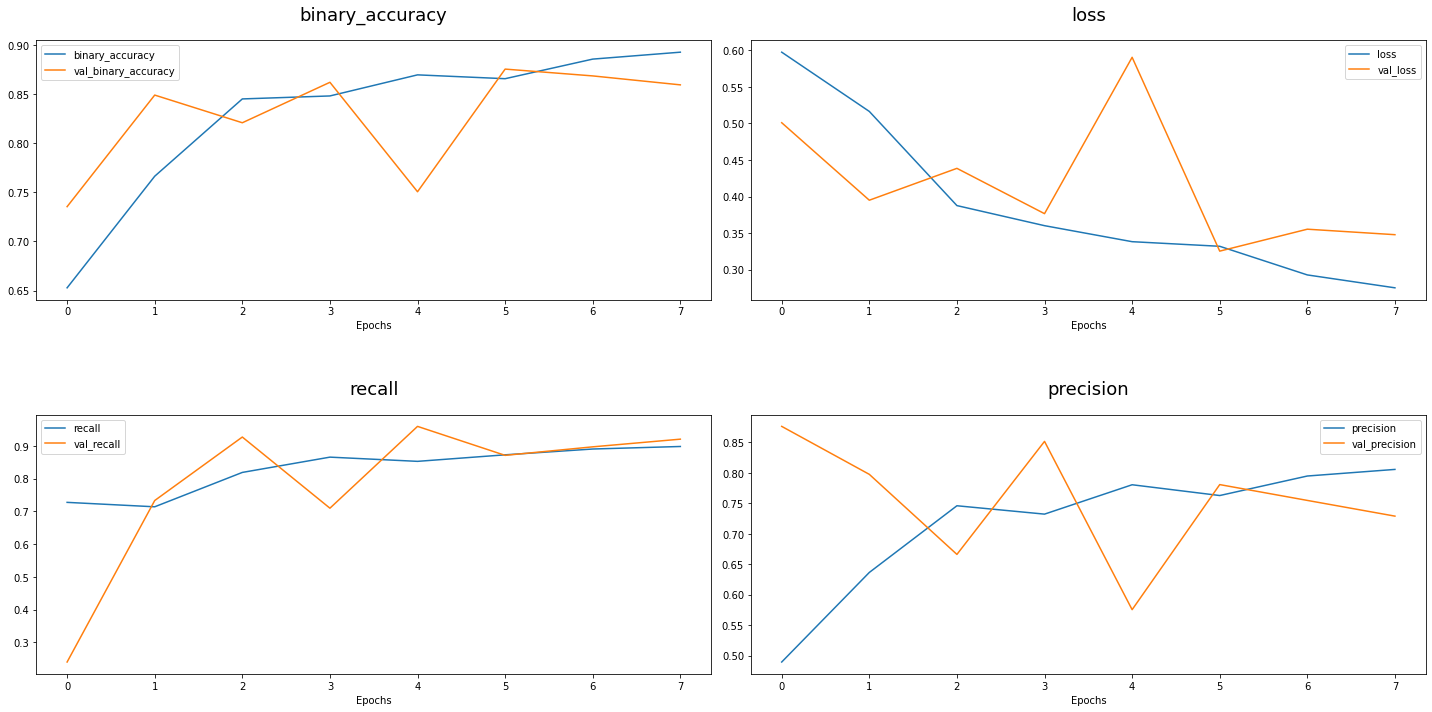

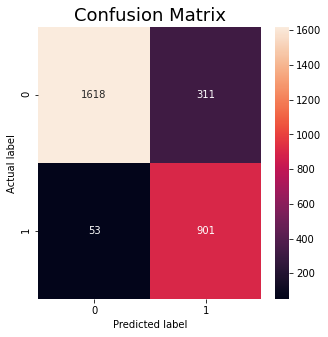

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)